In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from signals import *
from frequencyestimator import *
import time
import copy

sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .45, rc={"grid.linewidth": 0.8})

<Figure size 640x480 with 0 Axes>

In [3]:
P0 = lambda n, theta: np.cos((2*n+1)*theta)**2
P1 = lambda n, theta: np.sin((2*n+1)*theta)**2

def estimate_signal(depths, n_samples, theta, eta=0.0):
        signals = np.zeros(len(depths), dtype = np.complex128)
        cos_signal = np.zeros(len(depths), dtype = np.complex128)
        for i,n in enumerate(depths):
            # Get the exact measuremnt probabilities
            p0 = P0(n, theta)
            p1 = P1(n, theta)

            p0x = P0x(n,theta)
            p1x = P1x(n,theta)

            # Get the "noisy" probabilities by sampling and adding a bias term that pushes towards 50/50 mixture
            eta_n = (1.0-eta)**(n+1) # The error at depth n increases as more queries are implemented
            p0_estimate = np.random.binomial(n_samples[i], eta_n*p0 + (1.0-eta_n)*0.5)/n_samples[i]
            p1_estimate = 1 - p0_estimate
            # p1_estimate = np.random.binomial(n_samples[i], eta_n*p1 + (1.0-eta_n)*0.5)/n_samples[i]
            p0x_estimate = np.random.binomial(n_samples[i], eta_n*p0x + (1.0-eta_n)*0.5)/n_samples[i]
            p1x_estimate = 1.0 - p0x_estimate
            
            # Estimate theta
            theta_estimated = np.arctan2(p0x_estimate - p1x_estimate, p0_estimate - p1_estimate)

            # estimate cos(2n+1)2theta
            # cos_signal[i] = p0_estimate - p1_estimate
            
            # Store this to determine angle at theta = 0 or pi/2
            if i==0:
                p0mp1 = p0_estimate - p1_estimate

            # Compute f(n) - Eq. 3
            fi_estimate = np.exp(1.0j*theta_estimated)
            # fi_estimate = 2*p0_estimate - 1 + 1.0j*np.sqrt(1-(2*p0_estimate - 1)**2)
            # fi_estimate = 2*p0_estimate - 1
            # fi_estimate = np.cos((2*n+1)*2*theta)
            # fi_estimate = np.exp(1.0j*(2*n+1)*2*theta)
            # fi_estimate = 2*p0 - 1 + np.random.normal(0.0, 1/n_samples[i])

            # signals[i] = np.real(fi_estimate)
            signals[i] = fi_estimate
         
        return signals    

## Test eigenvalues of R

In [591]:
a = 0.3
theta = np.arcsin(a)
w = 2*theta

q=4

narray = [2]*(2*q)

ula_signal = TwoqULASignal(M=narray, C=10)
espirit = ESPIRIT()

depths = ula_signal.depths
n_samples = ula_signal.n_samples
# n_samples = [100 for _ in depths]
print(f'depths:{depths}')

signal = estimate_signal(depths, n_samples, theta)
cos_signal = np.real(signal)
sin_signal = np.imag(signal) #don't know
abs_sin = np.abs(sin_signal)

signs = np.sign(sin_signal) #these are the correct signs

random_signs = np.random.choice([-1, 1], size=len(signs))

print(signs)
#corrupt the signs
# signs[1:] = -1 * signs[1:]
# signs[1] = -1 * signs[1]
# signs[2] = -1 * signs[2]
print(random_signs)

csignal = cos_signal + 1.0j * random_signs * abs_sin

R1 = ula_signal.get_cov_matrix_toeplitz(csignal)
R2 = ula_signal.get_cov_matrix_toeplitz(signal)

theta_est1, eigs1 = espirit.estimate_theta_toeplitz(R1)
theta_est2, eigs2 = espirit.estimate_theta_toeplitz(R2)


fft1 = np.abs(np.fft.fft(R1/len(R1)))
fft2 = np.abs(np.fft.fft(R2/len(R2)))

print(f"max fourier coefficient: {(np.max(fft1), np.max(fft2))}")
print(f"l4 norm fourier coefficients: {(np.linalg.norm(fft1, 4), np.linalg.norm(fft2, 4))}")
# print(np.max(fft1), np.max(fft2))

# xaxis = [i*np.pi/(2*len(fft1)) for i in range(len(fft1))]
# plt.figure()
# plt.plot(xaxis, fft1)

# plt.figure()
# plt.plot(xaxis, fft2)
print(theta_est1, theta_est2)



depths:[  0   1   2   4   8  16  32  64 128]
[ 1.  1.  1. -1. -1.  1.  1. -1. -1.]
[ 1  1  1 -1  1  1  1 -1  1]
max fourier coefficient: (0.44388722462574304, 0.9883950472883922)
l4 norm fourier coefficients: (0.5088545962273373, 0.9883967339655365)
0.3062122510802995 0.30498158952368015


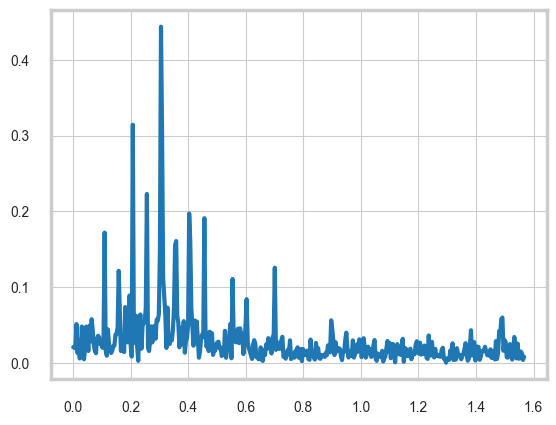

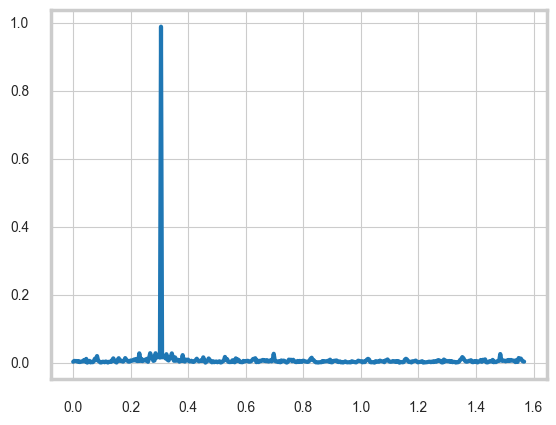

In [592]:
xaxis = [i*np.pi/(2*len(fft1)) for i in range(len(fft1))]
plt.figure()
plt.plot(xaxis, fft1)

plt.figure()
plt.plot(xaxis, fft2)

In [121]:
a = 0.5
theta = np.arcsin(a)
w = 2*theta

q=5

narray = [2]*(2*q)

ula_signal = TwoqULASignal(M=narray, C=3)
espirit = ESPIRIT()

depths = ula_signal.depths
n_samples = ula_signal.n_samples
# n_samples = [100 for _ in depths]
print(f'depths:{depths}')

signal = estimate_signal(depths, n_samples, theta)
cos_signal = np.real(signal)
sin_signal = np.imag(signal)
abs_sin = np.abs(sin_signal)

signs = np.sign(sin_signal) #these are the correct signs

plusminus = [1, -1]

s = np.ones(len(signal))

for i in range(1, len(signal)):
    obj = np.zeros(2)
    ula = TwoqULASignal(M=narray[:i], C=10)
    # print(ula.depths)
    for j, sign in enumerate(plusminus):
        s[i] = sign
        csignal = cos_signal[:i+1] + 1.0j * s[:i+1] * abs_sin[:i+1]
        
        R = ula.get_cov_matrix_toeplitz(csignal)
        theta_est, _ = espirit.estimate_theta_toeplitz(R)

        # print(len(R))
        fft = np.abs(np.fft.fft(R)/len(R))
        # print(fft)
        # obj[j] = np.linalg.norm(fft, 4)
        # obj[j] = np.abs(espirit.eigs[0])/np.abs(espirit.eigs[1])
        obj[j] = np.abs(espirit.eigs[0])

        # obj[j] = np.max(fft)
    # print(R)
    signal2 = signal[:i+1]
    R_true = ula.get_cov_matrix_toeplitz(signal2)

    _, _ = espirit.estimate_theta_toeplitz(R_true)
    # print(f"true: {np.abs(espirit.eigs[0])/np.abs(espirit.eigs[1])}")
    print(f"true: {np.abs(espirit.eigs[0])}")

    fft_true = np.abs(np.fft.fft(R_true)/len(R_true))
    # print(fft)
    # print(np.linalg.norm(fft_true, 4))

    print(f"+1 -1: {obj}")
    idx = np.argmax(obj)
    s[i] = plusminus[idx]
        
# np.dot(signs, s)/len(s)

csignal = cos_signal + 1.0j * s * abs_sin

R1 = ula_signal.get_cov_matrix_toeplitz(csignal)
R2 = ula_signal.get_cov_matrix_toeplitz(signal)

theta_est1, eigs1 = espirit.estimate_theta_toeplitz(R1)

theta_est2, eigs2 = espirit.estimate_theta_toeplitz(R2)

print(signs, s)

theta_est1, theta_est2, theta

    

depths:[  0   1   2   4   8  16  32  64 128 256 512]
true: 1.3302984583574047
+1 -1: [0.34519707 0.76688369]
true: 2.9619837939254
+1 -1: [1.88556214 2.93940699]
true: 8.949601899176553
+1 -1: [8.90777972 8.9496019 ]
true: 16.89918649919246
+1 -1: [14.56851106 16.8991865 ]
true: 48.37542556793399
+1 -1: [48.37542557 48.37542557]
true: 80.0088429661139
+1 -1: [61.68805915 80.00884297]
true: 218.43492795449555
+1 -1: [221.73546837 218.43492795]
true: 401.5325778762839
+1 -1: [246.12830689 404.66194016]
true: 1007.9325343789585
+1 -1: [1061.30331395  957.24946593]
true: 1869.3432230773296
+1 -1: [1272.32439352 1909.64011086]
[ 1.  1. -1. -1. -1.  1. -1. -1. -1. -1. -1.] [ 1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1.]


(0.5234804027757773, 0.5234968207189087, 0.5235987755982988)

## Brute force try all signs

In [96]:
a = 0.3
theta = np.arcsin(a)
w = 2*theta

q=4

narray = [2]*(2*q)

ula_signal = TwoqULASignal(M=narray, C=5)
espirit = ESPIRIT()

depths = ula_signal.depths
n_samples = ula_signal.n_samples
# n_samples = [100 for _ in depths]
print(f'depths:{depths}')

signal = estimate_signal(depths, n_samples, theta)
cos_signal = np.real(signal)
sin_signal = np.imag(signal)
abs_sin = np.abs(sin_signal)

signs = np.sign(sin_signal) #these are the correct signs

import itertools

def generate_sign_combinations(n):
    signs = [-1, 1]
    combinations = [np.array(combo) for combo in itertools.product(signs, repeat=n)]
    return combinations

# Example usage:
n = len(signal)

combinations = generate_sign_combinations(n)
obj = np.zeros(len(combinations))

for i, combo in enumerate(combinations):
    s = combo
    csignal = cos_signal + 1.0j * s * abs_sin
    R = ula.get_cov_matrix_toeplitz(csignal)
    # print(len(R))
    fft = np.abs(np.fft.fft(R)/len(R))
    # print(fft)
    norm = np.linalg.norm(fft, 4)
    obj[j] = norm
    print(norm)
    # obj[j] = np.max(fft)
        
# np.dot(signs, s)/len(s)
idx = np.argmax(obj)
s = combinations[idx]

csignal = cos_signal + 1.0j * s * abs_sin

R1 = ula_signal.get_cov_matrix_toeplitz(csignal)
R2 = ula_signal.get_cov_matrix_toeplitz(signal)

theta_est1, eigs1 = espirit.estimate_theta_toeplitz(R1)

theta_est2, eigs2 = espirit.estimate_theta_toeplitz(R2)

print(signs, s)

theta_est1, theta_est2, theta

    

depths:[  0   1   2   4   8  16  32  64 128]
0.4748157307149107
0.518729356677658
0.5272542470119677
0.5574700974886129
0.5175151936168857
0.49095870190311947
0.5498001772330591
0.5026954974656132
0.4875465105461915
0.5450169260928428
0.5186061473320236
0.5374760942160471
0.48259340130612455
0.5148299963792632
0.4493082746361294
0.46449459228880696
0.5707318451731445
0.5804140391529093
0.6659176012567107
0.6591164577975867
0.4054370660034026
0.4205011025507782
0.41464118597754057
0.403233711173294
0.5160830558205989
0.582459544467177
0.5567085104098319
0.5997926154286592
0.395805266399847
0.40315218731682156
0.42966090335338086
0.4131816029396922
0.4965157083000381
0.5183452975521994
0.5984899068564266
0.5787050160034135
0.4344659873551783
0.43098265587793727
0.48745019022790137
0.44629531070946665
0.7776709619703102
0.8084578603030327
0.8787813545026442
0.8891767072019199
0.4057323575696625
0.43072980181746207
0.4620988470607574
0.4871238932043842
0.8230238709256857
0.8892946120689526

(1.1675564338508735, 0.30500435241863233, 0.30469265401539747)

In [542]:
obj[idx]

0.3526757176636035

# Signal estimates on linear array

Use fft to find the angles when sampling the cosine on a linear array (so depths 0,1,2,3,4.., 1000 for example).
Theoretically this should give the correct peaks.
Also use ESPIRIT to find the peaks.

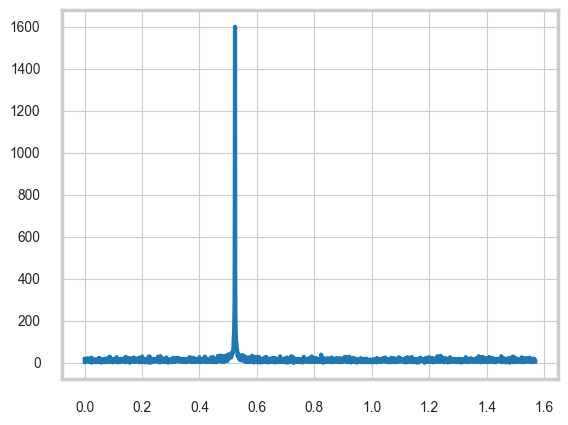

In [136]:
# Set the actual amplitude
theta = np.pi/6

theta1 = np.pi/5
theta2 = -theta1

depths = [i for i in range(2000)]
n_samples = [10 for d in depths]

R = estimate_signal(depths, n_samples, theta)

# R = [0.5*np.exp(1j*theta1*(2*d+1)) + 0.5*np.exp(1j*theta2*(2*d+1)) for d in depths]

fft = np.abs(np.fft.fft(R))

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

In [137]:
# amax = np.argmax(fft[:len(fft)//2])
amax = np.argmax(fft)
print(f'theta: {theta}')
print('peaks:', np.pi*(len(fft)-amax)/(2*len(fft)), np.pi*(amax)/(2*len(fft)))

theta: 0.5235987755982988
peaks: 1.0469357518087987 0.523860574986098


In [66]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle/4}')
print(f'theta_est: {theta_est}')
print(f'theta: {theta}')
np.sum(np.abs(angle))/8

angles: [-0.52386137  0.52386137]
theta_est: 0.5238613720505535
theta: 0.5235987755982988


0.5238613720505535

$(c_1 + x_1 i s_1, c_2 + x_2 i s_2, c_4 + x_4 i s_4)$

$(c_1 + x_1 i s_1)\cdot (c_2 + x_2 i s_2)$

## Get the real signal values on virtual locations 
One can do this using Chebyshev polynomials with the recurrence $\cos(nx) = 2\cos(x)\cos((n-1)x) - \cos((n-2)x)$

[0.3091371]
0.32404616978068135


(0.9456193887305278, 0.6251769380643689, 0.6283185307179586)

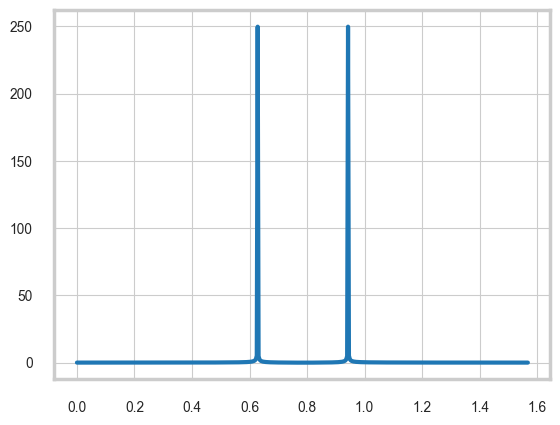

In [159]:
from scipy.special import chebyt, chebyu

def get_cheb_vals(n_max, w):
    R = np.zeros(n_max)
    for n in range(n_max):
        R[n] = chebyt(2*n+1)(np.cos(w))
    return R

def get_cosine_values(n_max, w):
    R = np.zeros(n_max)
    for n in range(n_max):
         R[n] = np.cos((2*n+1)*w)
    return R

# For reproducibility
# np.random.seed(8)

theta = np.pi/5
w = 2*theta

# depths = [0] + [2**i for i in range(6)]
depths = [0]
# n_samples = [(d_max - d)//2 + 1 for d in depths]
n_samples = [400 for _ in depths]

R = estimate_signal(depths, n_samples, theta)
print(R)
S = np.cos(w) + np.random.normal(0.0,1/100)
print(S)
vR = [chebyt(2*n+1)(R[0]) for n in range(500)]
R = vR
# R = get_cheb_vals(d_max, w)
# R = get_cosine_values(d_max, w)

fft = np.abs(np.fft.fft(R))

amax = np.argmax(fft[1:len(fft)//2])

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

np.pi*(len(fft)-amax)/(2*len(fft)), np.pi*(amax)/(2*len(fft)), theta

In [160]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle/2}')
print(f'theta_est: {2*theta_est}')
print(f'w: {w}')
np.sum(np.abs(angle))/4

angles: [ 1.25903098 -1.25903098]
theta_est: 1.882561675995292
w: 1.2566370614359172


1.259030977594501

This seems to work: Sample at depth 0 to get an approximation of $T_1(\cos(\omega)) = \cos(\omega)$ and use Chebyshev polynomials to get $T_{2n+1}(\cos(\omega)) = \cos((2n+1)\omega)$ and use ESPRIT or FFT.

Unfortunately, the scaling in this case is no better than classical since $|T_n(\cos(\omega)) - T_n(x)|< n\epsilon$ if $x = \cos(\omega)+\epsilon$ ($x$ being a noisy version of $\cos(\omega)$).

In [154]:
[2**k + 1 for k in range(1,9)]

[3, 5, 9, 17, 33, 65, 129, 257]

depths:[0, 1, 2, 4, 8, 16, 32]
idx_vals:[1, 3, 5, 9, 17, 33, 65]
{1: 0.30901699437494745, 3: -0.8090169943749475, 5: 1.0, 9: 0.309016994374947, 17: -0.8090169943749469, 33: -0.8090169943749483, 65: 1.0}
64


(0.9326603190344698, 0.6381360077604268, 0.6283185307179586)

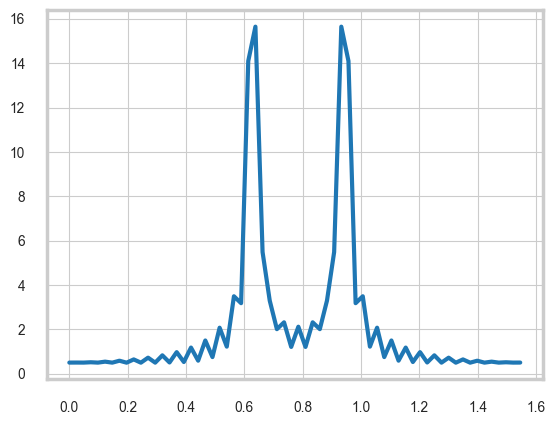

In [87]:
theta = np.pi/5# np.arccos(a)
w = 2*theta

q=6

depths = [0] + [2**i for i in range(q)]
n_samples = [100 for _ in depths]
print(f'depths:{depths}')

idx = [0]*

S = estimate_signal(depths, n_samples, theta)



fft = np.abs(np.fft.fft(R))

amax = np.argmax(fft[:len(fft)//2])

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

np.pi*(len(fft)-amax)/(2*len(fft)) , np.pi*(amax)/(2*len(fft)), theta

In [9]:
R = R[:len(R)//2]
len(R)

256

In [10]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle}')
print(f'w: {w}')
print(f'theta_est: {theta_est}')
print(f'theta:{theta}')
np.sum(np.abs(angle))/4

angles: [ 2.41720381 -2.41720381]
w: 2.0943951023931953
theta_est: 0.9664953736318308
theta:1.0471975511965976


1.2086019063261315

In [41]:
theta = np.pi/5
w = 2*theta
depths = [d for d in range(4000)]
n_samples = [10 for d in depths]
complex_signal = estimate_signal(depths=depths, n_samples=n_samples, theta=theta)

espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(complex_signal)
print(f'angles: {angle}')
print(f'w: {w}')
print(f'theta_est: {theta_est}')
print(f'theta:{theta}')

angles: [-2.51423504 -2.51474992]
w: 1.2566370614359172
theta_est: 0.6285587590036431
theta:0.6283185307179586


We need to solve the sign ambiguity at each depth. Consider the following approach.

Suppose we know $\cos(\omega)$, this implies $\sin(\omega) = \pm \sqrt{1-\cos^2(\omega)}$.

Choose a sign, say $+$. Then we form the exponential $e^{i\omega} = \cos(\omega) + i\sin(\omega)$.

Next we obtain $\cos(3\omega)$ as well and also choose $+$ for the sign, so we have $e^{i3\omega} = \cos(3\omega) + i\sin(3\omega)$.

Then, knowing $\cos(5\omega)$ determines if the chosen signs are consistent.

In [70]:
w = np.random.random()*np.pi
w

1.2734564911263488

In [74]:
std = 1/10**4

cos1 = np.cos(w) + np.random.normal(0.0, std)
sin1 = np.sqrt(1-cos1**2)

cos3 = np.cos(3*w) + np.random.normal(0.0, std)
sin3 = np.sqrt(1-cos3**2)

cos5 = np.cos(5*w) + np.random.normal(0.0, std)
sin5 = np.sqrt(1-cos5**2)

print(np.isclose(cos5, np.real((cos1+1.0j*sin1)**2*(cos3-1.0j*sin3)), rtol=0.01))

cos9 = np.cos(9*w) + np.random.normal(0.0, std)

print(np.isclose(cos9, np.real((cos1+1.0j*sin1) * (cos3-1.0j*sin3) * (cos5+1.0j*sin5)), rtol=0.01))

True
True


In [75]:
q = 3

s = [1] + [2**k+1 for k in range(1, q+1)]
s

[1, 3, 5, 9]

In [41]:
s[-1] - 2*s[0], s[-2] - s[0] + s[-3]# - s[0] + s[-4] - s[0] + s[-5]# - s[0]# + s[-6] - s[0] + s[-7] - s[0] + s[-8] - s[0] + s[-9]

(3, 3)

In [84]:
def sign_ambiguity(signal):
    # returns a list of signs at each depth
    signs = [1] #we can choose the first sign freely
    rtol = 0.01
    sines = np.sqrt(1 - signal**2)
    csignal = [signal[0] + signs[0]*1.0j*sines[0]] #first complex signal

    for i in range(1, len(signal) - 1):
        for sign in [-1, 1]:
            cs = signal[i] + sign*1.0j*sines[i]
            cs = cs * csignal[0]**2
            for j in range(i):
                cs = cs*csignal[j]*np.conj(csignal[0])

            if np.isclose(signal[i+1], np.real(cs), rtol=rtol):
                signs.append(sign)
                csignal.append(signal[i] + sign*1.0j*sines[i])
                break

    return signs, csignal

In [85]:
signal = np.array([np.cos(i*w)+np.random.normal(0.0, std) for i in s])
signal

array([ 0.29296457, -0.77816886,  0.99651255,  0.44893816])

In [86]:
sign_ambiguity(signal=signal)

([1, -1, 1],
 [(0.29296456924427944+0.9561232980988977j),
  (-0.778168857053688-0.6280551169378026j),
  (0.9965125488285425+0.08344303462387884j)])